# MRI Super Resolution with a Deep 3D Resnet Variant
# MSE + Perceptual Loss

# James Golden

## jgolden1@stanford.edu

## Problem setup 

A [high-resolution MRI dataset](http://old.mridata.org/fullysampled/knees) of knee volumes is blurred to simulate fast, low-resolution acquisition. A deep network was trained to carry out super resolution on the blurred volumetric data. There are 19 patients total, and 16 were used for training and validation while the remaining three were used for testing.

These fully-sampled 3D Fast Spin Echo, proton density weighted knee datasets are described in Epperson, et al., ["Creation of Fully Sampled MR Data Repository for Compressed Sensing of the Knee," SMRT Conference, Salt Lake City, UT, 2013. ](http://radiology.stanford.edu/blog/awards/Kevin_Epperson_SMRT_Poster_2013.pdf)

## Summary
- A dataset of 32x32x32 voxel volumes was generated from DICOM MRI data for 19 patients of size 512x512x252.
- The volume data was blurred with numpy.ndimage.gaussian to simulate fast, low-resolution acquisition.
- A data loader was built with pytorch and the fastai toolbox to create training and validation sets for data from 16 patients.
- The custom loader allowed for data augmentation - dihedral transforms implemented for 3D data.
- A super resolution network was implemented generally following "Enhanced Deep Residual Networks..." (Lim et al. 2017) using 14 residual blocks of 64 3x3x3 conv kernels.
- The loss function was a custom perceptual loss using MSE + the first three conv layers of VGG16 activations built for all possible 2D slices of the volumes.
- The perceptual loss allowed the network to learn more accurate super resolution output volumes over conventional MSE.




<p align="center"> 
<img src="volume_animations/mri_p6.gif">
</p>

## General approach

I implemented a resnet-like 3D super resolution network in Pytorch. I generated a training set of 32x32x32 volume blocks from the MRI data for each of the 19 patients, and trained/validated on the first 15 patients and tested on the last 4 patients. The network is fully convolutional, so it can be trained on small volumes and tested on any size volume.

The network I built generally followed the approach of "Enhanced Deep Residual Networks for Single Image Super-Resolution" (https://arxiv.org/abs/1707.02921 by Bee Lim, Sanghyun Son, Heewon Kim, Seungjun Nah, Kyoung Mu Lee), but adapted for 3D volume data. The residual block was composed of 64 3x3x3 conv kernels followed by a ReLu followed by another block of 64 3x3x3 conv kernels, and I used a total of 9 res blocks. (I wanted to use more, but this filled up the 12 GB of GPU memory I had available.) 

In the other notebook in this repo, I implemented the original version of this network with MSE loss. Here I supplement the loss function with a perceptual loss based on the first three convolutional layers of VGG16. At the end I compare the super resolution volumes from the only MSE-loss network and the MSE + perceptual loss network, and find that the perceptual loss indeed improves the resolution.

I also used the Fast AI toolbox as well (https://github.com/fastai by Jeremy Howard, Rachel Thomas, et al., a bit like Keras for Pytorch), which has a nice data loader tool that comes with easy data augmentation. Fast AI also has a super resolution image demo with a resnet variant that I used as a scaffold for my network, as well as code for perceptual loss with VGG16 that I expanded upon.

## Conclusions

3D convolutional kernels are necessary to take full advantage of the structure of the input data. MSE loss with a typical resnet structure works to a degree, but adding a perceptual component with VGG16 activations further improves the super resolution output

## Imports

In [1]:
# Imports

from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

import glob
import h5py
# fastai
import sys
sys.path.append('/home/james/Documents/pyt/fastai')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from pathlib import Path

# from scipy import signal

## Build training data

In order to load the DICOM MRI volume data, the pydicom toolbox was used. The data was read and the slices were ordered using the pydicom get method for 'SliceLocation'. The data is normalized to intensities between 0 and 1.

In [7]:
# Load dicom data
import glob
dicom_folder = '/home/james/Documents/subtle/unzipped/P6/'

image_files =glob.glob(dicom_folder+'/*.mag')

# Us3e pydicom to get the volume data
slices2d = [pydicom.dcmread(image_file) for image_file in image_files]

# Sort slices by z dim
imdata = np.zeros([list(np.shape(slices2d[0].pixel_array))[0],list(np.shape(slices2d[0].pixel_array))[1],len(slices2d)])
sloc = []
for ii in range(len(slices2d)):
    sloc.append(slices2d[ii].get('SliceLocation'))
# plt.plot(sloc,marker='x')

# Store as numpy array
ssort = np.argsort(sloc)

for ii in range(len(slices2d)):
    imdata[:,:,ii] = slices2d[ssort[ii]].pixel_array
    
    
imdata *= 1.0/np.max(imdata[:])


In [8]:
# Blur with equal sigma gaussian filter for three dimensions
from scipy.ndimage import gaussian_filter
sigma_filt = 5.
imfilt = gaussian_filter(imdata, sigma=sigma_filt, mode = 'constant')


Text(0.5,1,'Blurred Slice')

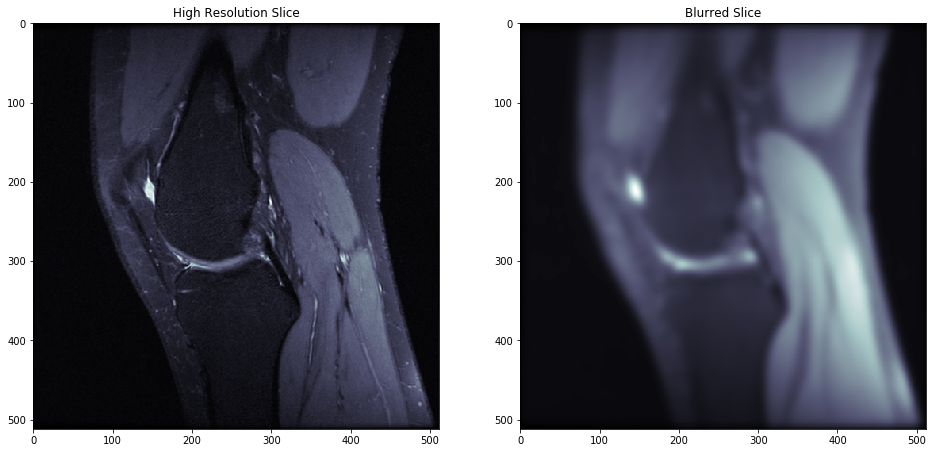

In [9]:
fig=plt.figure(figsize=[16,16])
plt.subplot(1,2,1)
plt.imshow(np.squeeze(imdata[:,:,128]),cmap = plt.cm.bone)
plt.title('High Resolution Slice')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(imfilt[:,:,128]),cmap = plt.cm.bone)
plt.title('Blurred Slice')

### Store data in 32x32x32 volumes for training and save as h5 files

In [ ]:
# Set patient number
pf = 4

# Destination directory
dtrainx = '/home/james/Documents/subtle/batches_sc/train/p'+str(pf)
if not os.path.exists(dtrainx):
    os.makedirs(dtrainx)

# Break into 32x32x32 volumes
pixdim = 32
pixsize = 512
ctr = 0
for xi in range(0,pixsize,pixdim):
    for yi in range(0,pixsize,pixdim):
        for zi in range(pixdim/2,len(slices2d)-pixdim/2,pixdim):

            # iterate through small volume subsets and save
            ctr += 1
            vol_y = imdata[xi:xi+pixdim, yi:yi+pixdim, zi:zi+pixdim]

            # check that variance is high so that region isn't just empty
            if np.std(vol_y.flatten()) > 0.01:
                # Do some padding if necessary and save high-res block
                vol_y *= 1.0/np.max(vol_y[:])   
                
                if np.shape(vol_y[2]<32):
                    vol_y = np.pad(vol_y,((0,0),(0,0),(0,4)),'reflect')

                hf = h5py.File(dtrainx+'/vol_p'+str(pf)+'_'+str(ctr)+'_y.h5', 'w')
                hf.create_dataset('data1', data=vol_y)
                hf.close()

                # Do some padding if necessary and save low-res block
                vol_x = imfilt[xi:xi+pixdim, yi:yi+pixdim, zi:zi+pixdim]
                vol_x *= 1.0/np.max(vol_x[:])  
                if np.shape(vol_x[2]<32):
                    vol_x = np.pad(vol_x,((0,0),(0,0),(0,4)),'reflect')

                hf = h5py.File(dtrainx+'/vol_p'+str(pf)+'_'+str(ctr)+'.h5', 'w')
                hf.create_dataset('data1', data=vol_x)
                hf.close()

## Load training data

In [3]:

PATH = Path('/home/james/Documents/mri/batches')
PATH_TRN = PATH/'train'

fnames_full,label_arr_full,all_labels = folder_source(PATH, 'train')

# Get only the list of blurred 32x32x32 volume hdf files, originals have 'y' in file name
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full if 'y' not in fn]

In [5]:
# Set aside a portion for validation
np.random.seed(42)
keep_pct = 1.
keeps = np.random.rand(len(fnames_full)) < 10
fnames = np.array(fnames_full, copy=False)[keeps]

In [6]:
# Get only the original, non-blurred volumes
fnamesy = [fi[:-3] + '_y.h5' for fi in fnames]

### Compare file names for x and y to make sure the correct blurred and original volumes are paired together

In [7]:
list(zip(fnames[:5],fnamesy[:5]))

[('p0/vol_p0_63.h5', 'p0/vol_p0_63_y.h5'),
 ('p0/vol_p0_1004.h5', 'p0/vol_p0_1004_y.h5'),
 ('p0/vol_p0_467.h5', 'p0/vol_p0_467_y.h5'),
 ('p0/vol_p0_1876.h5', 'p0/vol_p0_1876_y.h5'),
 ('p0/vol_p0_340.h5', 'p0/vol_p0_340_y.h5')]

In [9]:
# Set batch size and size of input and output training volume blocks
bs = 1
sz_lr = 32
sz_hr = sz_lr

### Build a custom data loader for fast ai that can handle volume data
(Note: there are many additional changes I made to the data loader code in my fork of the fast ai repo)

In [10]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, fnamesy, transform, path):
        self.fnamesy=fnamesy
        assert(len(fnames)==len(fnamesy))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_volume(os.path.join(self.path, self.fnamesy[i]))
    def get_c(self): return 0

### Set data augmentation
The random dihedral augmentation for 2D images from FastAI was expanded to do the same for 3D volume data.

In [12]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]
# aug_tfms = [PassThru(tfm_y=TfmType.PIXEL)]

### Build the training and validation sets for both blurred and original volume block data
I created a small validation set on purpose because I knew I would not have time to ensemble networks From different k-fold cross-validated training sessions. I would have done that with more time. The small validation set allowed me to maximize the accuracy of the network given the training data.

I also realize the training set is quite small. I removed volume blocks with variance below a certain threshold in order to avoid training on volumes with no interesting anatomical data. Ideally augmentation will improve this.

In [13]:
# Split training and validation sets
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnamesy))
len(val_x),len(trn_x)

(168, 16635)

## Apply the custom data loader to prepare the training data

In [14]:
# Apply data augmentations - rotations and flips in all three dimensions, 27 possible for a block
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)

# Create the custom data loader for the network with the training data. See fast ai documentation for more details. 
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
# datasets = ImageData.get_ds(FilesXYDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)

# Initialize the pytorch model with the training data
md = ImageData(PATH, datasets, bs, num_workers=1, classes=None)

In [17]:
# Check the data loader
md.trn_dl

In [18]:
# Check sizes of training set: (batch, channel, x, y, z)
x,y = next(iter(md.trn_dl))
x.size(),y.size()

(torch.Size([64, 1, 32, 32, 32]), torch.Size([64, 1, 32, 32, 32]))

## Check images of the volume data to make sure it looks good
Check that the blurred volumes generally match the original volumes

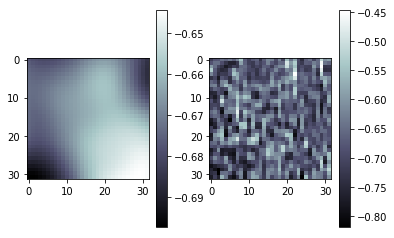

In [23]:
plt.subplot(1,2,1)
bind = 4
plt.imshow(torch.squeeze(x[bind,0,7,:,:]),cmap=plt.cm.bone)

plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(torch.squeeze(y[bind,0,7,:,:]),cmap=plt.cm.bone)

plt.colorbar()

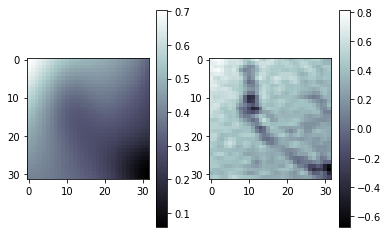

In [24]:
plt.subplot(1,2,1)
bind = 3
plt.imshow(torch.squeeze(x[bind,0,:,:,7]),cmap=plt.cm.bone)

plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(torch.squeeze(y[bind,0,:,:,7]),cmap=plt.cm.bone)

plt.colorbar()

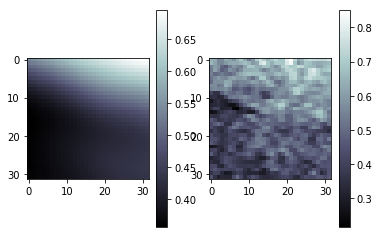

In [25]:
plt.subplot(1,2,1)
# bind = 46
plt.imshow(torch.squeeze(x[bind,0,:,7,:]),cmap=plt.cm.bone)

plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(torch.squeeze(y[bind,0,:,7,:]),cmap=plt.cm.bone)

plt.colorbar()

## Check 3D slices to make sure blurred and original data match

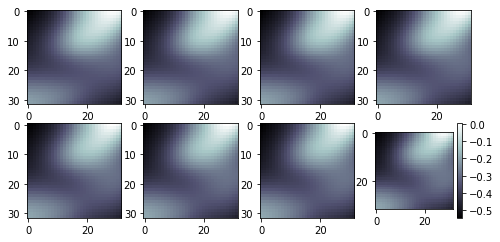

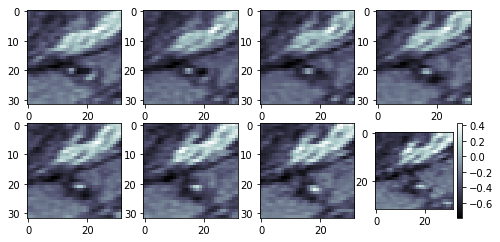

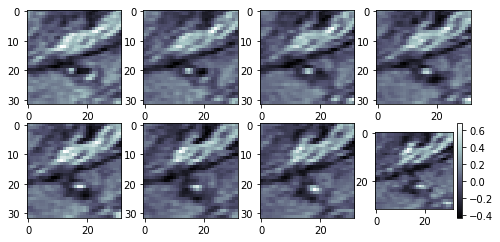

In [29]:

bind = 1
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(x[bind,0,pi,:,:]),cmap=plt.cm.bone)
    
plt.colorbar()

# np.shape(preds)
# bind = 62
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,pi,:,:]),cmap=plt.cm.bone)
    
plt.colorbar()

# np.shape(preds)
# bind = 39
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,pi,:,:]-x[bind,0,pi,:,:]),cmap=plt.cm.bone)
plt.colorbar()

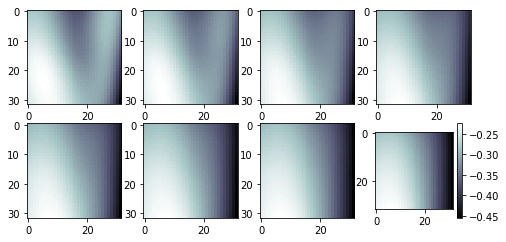

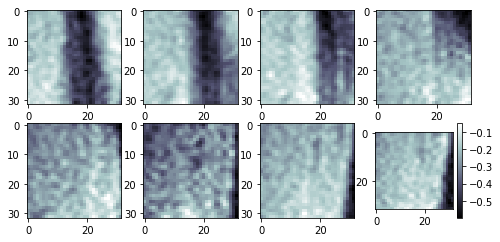

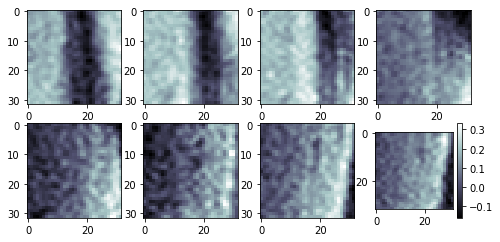

In [30]:

bind =0
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(x[bind,0,:,pi,:]),cmap=plt.cm.bone)
    
plt.colorbar()

# np.shape(preds)
# bind = 39
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,:,pi,:]),cmap=plt.cm.bone)
    
plt.colorbar()

# np.shape(preds)
# bind = 39
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,:,pi,:]-x[bind,0,:,pi,:]),cmap=plt.cm.bone)
plt.colorbar()

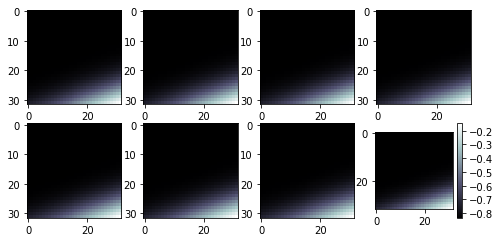

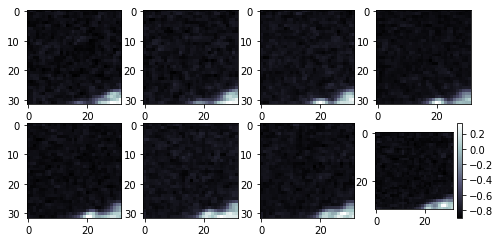

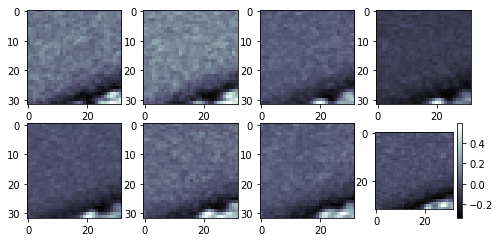

In [31]:

bind = 2
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(x[bind,0,:,pi,:]),cmap=plt.cm.bone)
    
plt.colorbar()

# np.shape(preds)
# bind = 39
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,:,pi,:]),cmap=plt.cm.bone)
    
plt.colorbar()

# np.shape(preds)
# bind = 39
plt.figure(figsize=[8,8])
for pi in range(8):
    plt.subplot(4,4,pi+1)
    plt.imshow(torch.squeeze(y[bind,0,:,pi,:]-x[bind,0,:,pi,:]),cmap=plt.cm.bone)
plt.colorbar()

(array([305., 122.,  63., 135., 146.,  55.,  25.,  40.,  92.,  41.]),
 array([-0.9279 , -0.85043, -0.77295, -0.69548, -0.61801, -0.54054, -0.46307, -0.38559, -0.30812, -0.23065,
        -0.15318]),
 <a list of 10 Patch objects>)

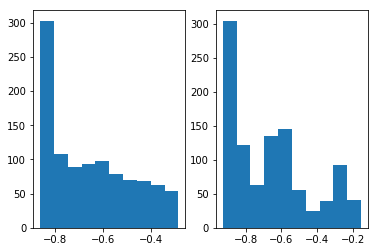

In [32]:
plt.subplot(1,2,1)
bind = 5
xi = torch.squeeze(x[bind,0,7,:,:])[:]
plt.hist(xi[:].cpu().numpy().flatten())

# plt.colorbar()
plt.subplot(1,2,2)
# plt.imshow(torch.squeeze(y[bind,0,16,:,:]),cmap=plt.cm.bone)

yi = torch.squeeze(y[bind,0,7,:,:])[:]
plt.hist(yi[:].cpu().numpy().flatten())


# Build the resnet for super resolution

#### A resnet-like 3D super resolution network in Pytorch.

The network I built generally followed the approach of "Enhanced Deep Residual Networks for Single Image Super-Resolution" (https://arxiv.org/abs/1707.02921), but adapted for 3D volume data. The residual block was composed of 64 3x3x3 conv kernels followed by a ReLu followed by another block of 64 3x3x3 conv kernels, and I used a total of 14 res blocks (see FastAI notebook "enhance.ipynb" for source).

### The network was assembled in a modular fashion:

First, a 3D convolution block with a 3x3x3 kernal was designed:

In [10]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv3d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [11]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

In [12]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf*1, actn=True), conv(nf*1, nf)],
        1.0)

In [13]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(1, nf)]
        for i in range(14): features.append(res_block(nf))
        features += [conv(nf,nf*1), #upsample(64, 64, scale),
#                      nn.BatchNorm2d(nf),
                     conv(nf*1, 1)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

## Perceptual loss

A pytorch implementation of VGG16 is loaded in eval mode in order to get feature activations for both the high-res training blocks as well as the network output for predicted high-res blocks. The gradients for the super res network can be taken through the feature activation comparisons from the VGG network.

Following the original FastAI approach, only the first three convolutional blocks are used for feature activations.

Since the FastAI code was written for 2D images, I expanded the perceptual loss function to calculate the feature activations for every possible 2D slice of the 32x32x32 training volume data. 

In [14]:
m_vgg = vgg16(True)

In [15]:
blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.AvgPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [42]:
# m_vgg
# children(m_vgg)
# blocks

In [43]:
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [44]:
def flatten(x): return x.view(x.size(0), -1)

In [45]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

### The perceptual loss function

VGG16 expects a 3-channel RGB image, so here every 2D slice of the 32x32x32 volume data is transformed into a 3x32x32 image, and the appropriate means and stdevs are set for the RGB channels. 

The feature activations are calculated for each slice and the loss function is composed iteratively. Here the raw MSE is included as well for an approximate 50-50 balanced contribution between MSE and perceptual losses.

In [47]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]
    
    def forward(self, input, target, sum_layers=True):
        
        zsize = np.size(target.data,2)
        
        # divided by 10 sets MSE and Perceptual magnitudes equal initially
        res = [F.mse_loss(V(input, requires_grad = True),VV(target))/10]#/(zsize*3*100)]

        # Set VGG16 mean and stdev
        mean0, mean1, mean2 = 0.485, 0.456, 0.406
        std0, std1, std2 = 0.229, 0.224, 0.225

        # Rescale training batch mean and stdev to match VGG16
        input = input - torch.mean(input[:]) 
        
        target = target - torch.mean(target[:])

        input2 = input.clone()
        input2.retain_grad()
        input2 = input2.expand(-1,3,-1,-1,-1)
        input2[:,0,:,:,:] = mean0+std0*(input2[:,0,:,:,:].clone())/torch.std(input[:])#.data
        input2[:,1,:,:,:] = mean1+std1*(input2[:,0,:,:,:].clone())/torch.std(input[:])#.data
        input2[:,2,:,:,:] = mean2+std2*(input2[:,0,:,:,:].clone())/torch.std(input[:])#.data

        target2 = target.clone()
        target2.retain_grad()
        target2 = target2.expand(-1,3,-1,-1,-1)
        target2[:,0,:,:,:] = mean0+std0*(target2[:,0,:,:,:].clone())/torch.std(target[:])#.data
        target2[:,1,:,:,:] = mean1+std1*(target2[:,0,:,:,:].clone())/torch.std(target[:])#.data
        target2[:,2,:,:,:] = mean2+std2*(target2[:,0,:,:,:].clone())/torch.std(target[:])#.data
            
        # Loop over each slice in each dimension
        for ii in range(zsize):
            
            input3z = torch.squeeze(input2[:,:,:,:,ii])
            target3z = torch.squeeze(target2[:,:,:,:,ii])
            self.m(VV(target3z))
      
            targ_feat = [V(o.features.data.clone()) for o in self.sfs]
            self.m(V(input3z, requires_grad = True))
            # Compute perceptual loss by measuring L1 norm of feature activation differences
            res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt/(3*zsize)
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
                       
        for ii in range(zsize):
            
            input3y = torch.squeeze(input2[:,:,:,ii,:])
            target3y = torch.squeeze(target2[:,:,:,ii,:])
            self.m(VV(target3y))
            
            targ_feat = [V(o.features.data.clone()) for o in self.sfs]
            self.m(V(input3y, requires_grad = True))
            res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt/(3*zsize)
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
                                    
        for ii in range(zsize):
                    
            input3x = torch.squeeze(input2[:,:,ii,:,:])
            target3x = torch.squeeze(target2[:,:,ii,:,:])
            self.m(VV(target3x))

            targ_feat = [V(o.features.data.clone()) for o in self.sfs]
            self.m(V(input3x, requires_grad = True))
            res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt/(3*zsize)
                   for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
    
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [161]:
m = SrResnet(64, 1.)

In [164]:
m = to_gpu(m)

In [165]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [59]:
learn.set_data(md)

In [60]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])
# learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.5,0.4,0.1])

In [61]:
blocks[:3]

[5, 12, 22]

In [63]:
learn.model

SrResnet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (1): ResSequential(
      (m): Sequential(
        (0): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU(inplace)
        )
        (1): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
      )
    )
    (2): ResSequential(
      (m): Sequential(
        (0): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU(inplace)
        )
        (1): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
      )
    )
    (3): ResSequential(
      (m): Sequential(
        (0): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          

In [62]:
wd = 1e-5

# Training

In [65]:
lr = 7e-4
learn.fit(lr*1, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.015462   0.013653  



[array([0.01365])]

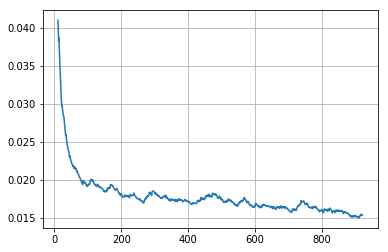

In [66]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [67]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep1')

In [68]:
lr = 7e-4
learn.fit(lr*.65, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.01408    0.012777  



[array([0.01278])]

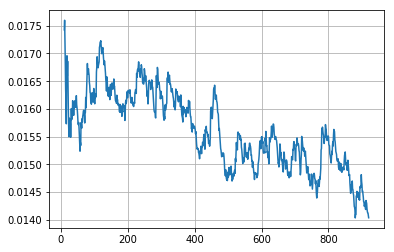

In [69]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [70]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep2')

In [71]:
lr = 7e-4
learn.fit(lr*.5, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.013427   0.012332  



[array([0.01233])]

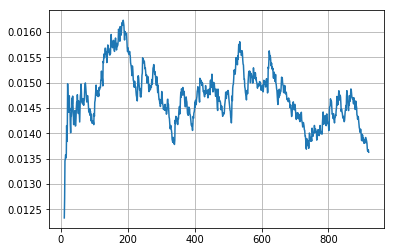

In [72]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [73]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep3')

In [74]:
lr = 7e-4
learn.fit(lr*.4, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.012613   0.012102  



[array([0.0121])]

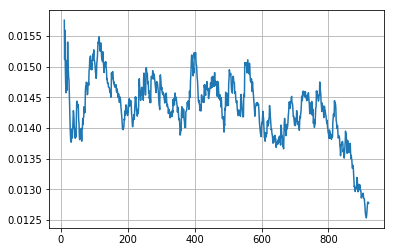

In [75]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [76]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep4')

In [77]:
lr = 7e-4
learn.fit(lr*.3, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013596   0.011935  



[array([0.01194])]

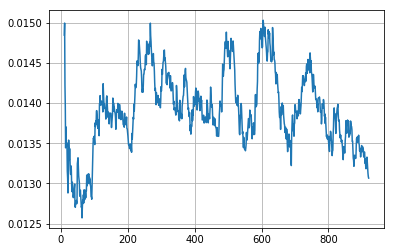

In [78]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [79]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep5')

In [80]:
lr = 7e-4
learn.fit(lr*.25, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.014103   0.011799  



[array([0.0118])]

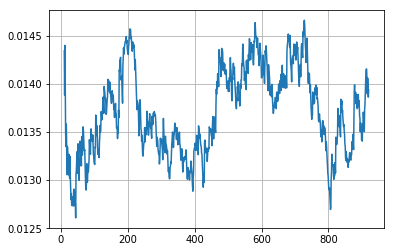

In [81]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [82]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep6')

In [83]:
lr = 7e-4
learn.fit(lr*.2, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.01287    0.011694  



[array([0.01169])]

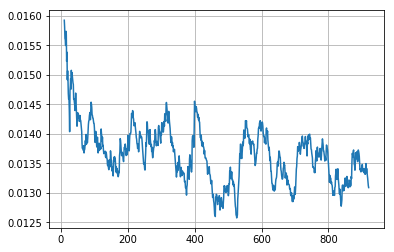

In [84]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [85]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep7')

In [86]:
lr = 7e-4
learn.fit(lr*.15, 1, cycle_len=1, wds=wd, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.013666   0.011624  



[array([0.01162])]

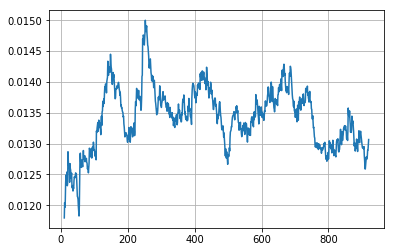

In [87]:
learn.sched.plot_loss()
plt.grid()
# plt.ylim([0.01,.02])

In [88]:
# learn.save('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep8')

# Test on held-out volumes

The total dataset has 252x512x512 volumes for 19 patients. The network was trained on 16 patients with 1% of the volumes held out for validation. The remaining three patient volumes were used for testing below.

In [166]:

learn.load('/home/james/Documents/mri/saved_models/nov3_perceptual_50mse_14_chnorm_aug_rep8')

In [ ]:
# def build_3d(dicom_folder):

import glob
dicom_folder = '/home/james/Documents/subtle/unzipped/P6/'

image_files =glob.glob(dicom_folder+'/*.mag')

slices2d = [pydicom.dcmread(image_file) for image_file in image_files]

imdata = np.zeros([list(np.shape(slices2d[0].pixel_array))[0],list(np.shape(slices2d[0].pixel_array))[1],len(slices2d)])
sloc = []
for ii in range(len(slices2d)):
    sloc.append(slices2d[ii].get('SliceLocation'))
# plt.plot(sloc,marker='x')

ssort = np.argsort(sloc)

for ii in range(len(slices2d)):
    imdata[:,:,ii] = slices2d[ssort[ii]].pixel_array
    
    
imdata *= 1.0/np.max(imdata[:])


from scipy.ndimage import gaussian_filter
sigma_filt = 5.
imfilt = gaussian_filter(imdata, sigma=sigma_filt, mode = 'constant')

im5dsh = [1,1]
im5dsh.extend(list(np.shape(imfilt)))
im5d = np.zeros(im5dsh)
im5d[0,0,:,:,:]=imfilt
predsmse = learn.model(VV(im5d[0:1,0:1,:,:,105:136]))

### A comparison between only MSE loss and (MSE + Perceptual) loss
The top right image is the high-res original data, the top left image is the blurred input, the bottom left is the MSE only super resolution output and the bottom right is the (MSE+Perceptual) super resolution output.

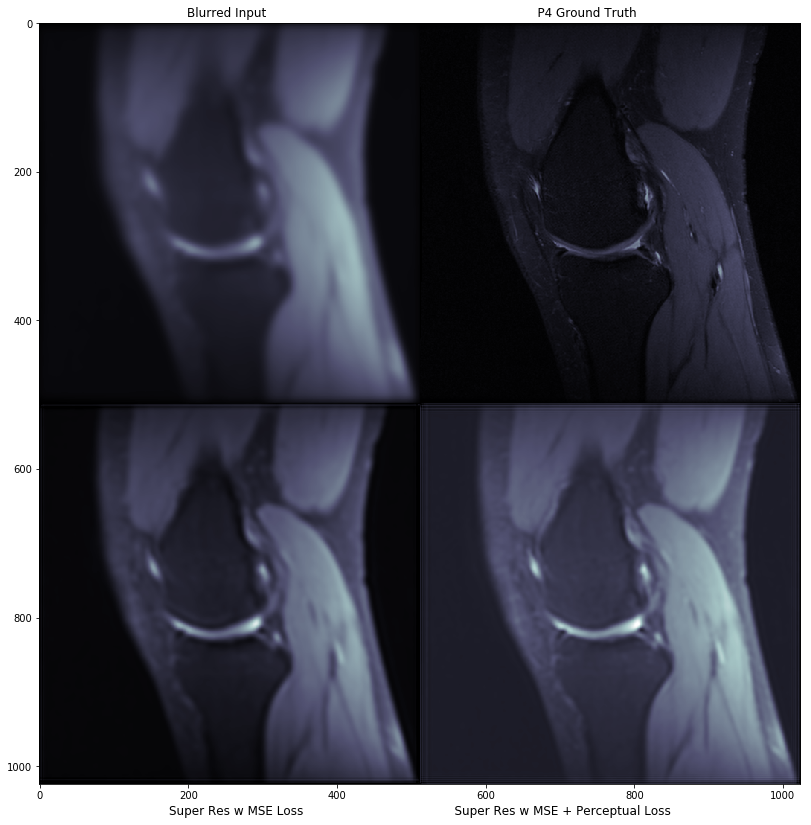

In [145]:


predsNP = preds[0:1,0:1,:,:,:].data.cpu().numpy()
predsNP2 = predsmse[0:1,0:1,:,:].data.cpu().numpy()

imfilt *= 1.0/np.max(imfilt[:])

predsNP *= 1.0/np.max(predsNP[:])

predsNP2 *= 1.0/np.max(predsNP2[:])

maxi = 0.5
imbig = np.zeros([512*2,512*2,31])
for i in range(31):
    imsr = predsNP[0:1,0:1,:,:,i]
    imsr2 = predsNP2[0:1,0:1,:,:,i]
    imbig[0:512,0:512,i] = imfilt[:,:,i+105]
    imbig[0:512,512+0:512+512,i] = 1.5*imdata[:,:,i+105]#
    imbig[512+0:512+512,0:512,i] = imsr2
    imbig[512+0:512+512,512+0:512+512,i] = imsr
    
fig = plt.figure(figsize=[14,14])
ims = []
for i in range(31):
    im = plt.imshow(imbig[:,:,i], animated=True,cmap=plt.cm.bone)
    plt.clim([0,0.75])
    plt.title('Blurred Input                                                                      P4 Ground Truth    ')
    plt.xlabel('Super Res w MSE Loss                                       Super Res w MSE + Perceptual Loss', fontsize = 12)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=4*50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

#plt.show()
HTML(ani.to_html5_video())

The top right image is the high-res original data, the top left image is the blurred input, the bottom left is the MSE only super resolution output and the bottom right is the (MSE+Perceptual) super resolution output.

In [146]:
# def build_3d(dicom_folder):

import glob
dicom_folder = '/home/james/Documents/subtle/unzipped/P20/'

image_files =glob.glob(dicom_folder+'/*.mag')

slices2d = [pydicom.dcmread(image_file) for image_file in image_files]

imdata = np.zeros([list(np.shape(slices2d[0].pixel_array))[0],list(np.shape(slices2d[0].pixel_array))[1],len(slices2d)])
sloc = []
for ii in range(len(slices2d)):
    sloc.append(slices2d[ii].get('SliceLocation'))
# plt.plot(sloc,marker='x')

ssort = np.argsort(sloc)

for ii in range(len(slices2d)):
    imdata[:,:,ii] = slices2d[ssort[ii]].pixel_array
    
    
imdata *= 1.0/np.max(imdata[:])


from scipy.ndimage import gaussian_filter
sigma_filt = 5.
imfilt = gaussian_filter(imdata, sigma=sigma_filt, mode = 'constant')


im5dsh = [1,1]
im5dsh.extend(list(np.shape(imfilt)))
im5d = np.zeros(im5dsh)
im5d[0,0,:,:,:]=imfilt
preds = learn.model(VV(im5d[0:1,0:1,:,:,105:136]))

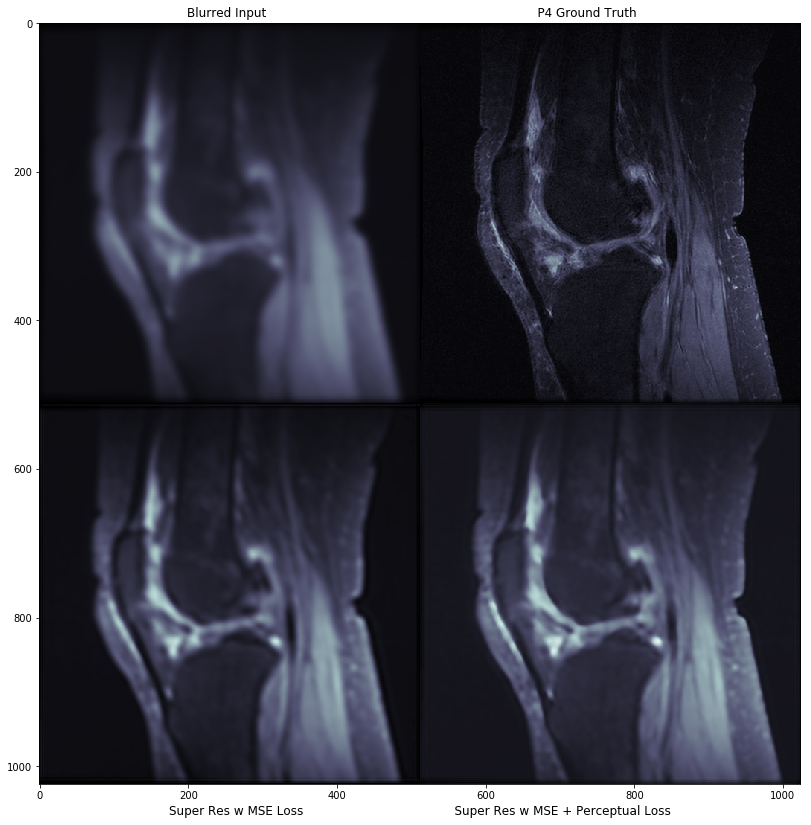

In [168]:


predsNP = preds[0:1,0:1,:,:,:].data.cpu().numpy()
predsNP2 = predsmse[0:1,0:1,:,:].data.cpu().numpy()

imfilt *= 1.0/np.max(imfilt[:])

predsNP *= 1.0/np.max(predsNP[:])

predsNP2 *= 1.0/np.max(predsNP2[:])

maxi = 0.5
imbig = np.zeros([512*2,512*2,31])
for i in range(31):
    imsr = predsNP[0:1,0:1,:,:,i]
    imsr2 = predsNP2[0:1,0:1,:,:,i]
    imbig[0:512,0:512,i] = imfilt[:,:,i+105]
    imbig[0:512,512+0:512+512,i] = 1.5*imdata[:,:,i+105]#
    imbig[512+0:512+512,0:512,i] = imsr2
    imbig[512+0:512+512,512+0:512+512,i] = imsr
    
fig = plt.figure(figsize=[14,14])
ims = []
for i in range(31):
    im = plt.imshow(imbig[:,:,i], animated=True,cmap=plt.cm.bone)
    plt.clim([0,0.75])
    plt.title('Blurred Input                                                                      P4 Ground Truth    ')
    plt.xlabel('Super Res w MSE Loss                                       Super Res w MSE + Perceptual Loss', fontsize = 12)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=4*50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

#plt.show()
HTML(ani.to_html5_video())

The top right image is the high-res original data, the top left image is the blurred input, the bottom left is the MSE only super resolution output and the bottom right is the (MSE+Perceptual) super resolution output.

In [170]:
# def build_3d(dicom_folder):

import glob
dicom_folder = '/home/james/Documents/subtle/unzipped/P4/'

image_files =glob.glob(dicom_folder+'/*.mag')

slices2d = [pydicom.dcmread(image_file) for image_file in image_files]

imdata = np.zeros([list(np.shape(slices2d[0].pixel_array))[0],list(np.shape(slices2d[0].pixel_array))[1],len(slices2d)])
sloc = []
for ii in range(len(slices2d)):
    sloc.append(slices2d[ii].get('SliceLocation'))
# plt.plot(sloc,marker='x')

ssort = np.argsort(sloc)

for ii in range(len(slices2d)):
    imdata[:,:,ii] = slices2d[ssort[ii]].pixel_array
    
    
imdata *= 1.0/np.max(imdata[:])


from scipy.ndimage import gaussian_filter
sigma_filt = 5.
imfilt = gaussian_filter(imdata, sigma=sigma_filt, mode = 'constant')


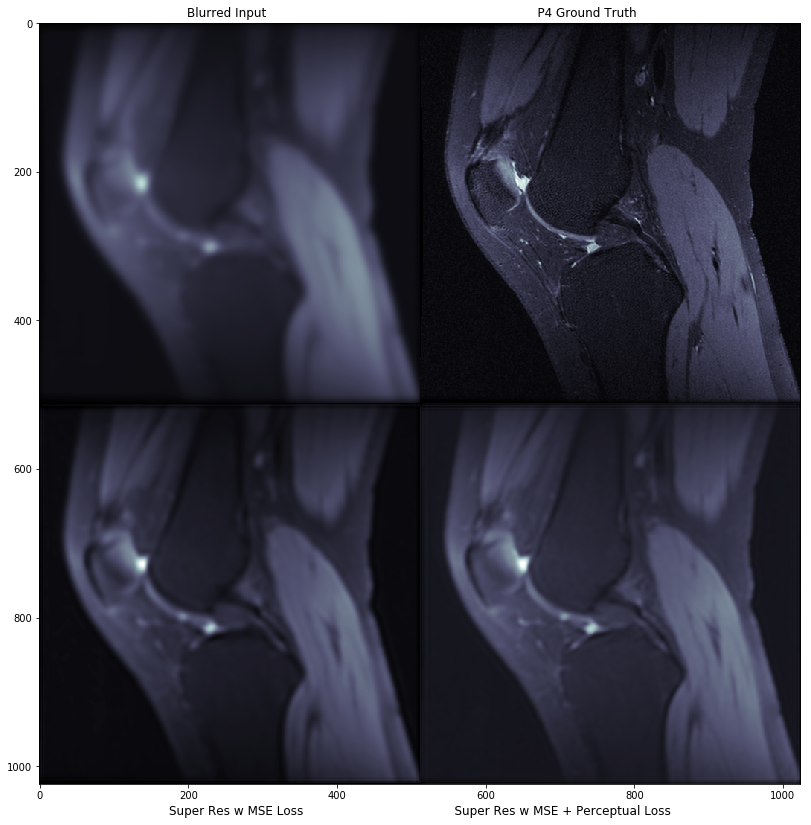

In [176]:


predsNP = preds[0:1,0:1,:,:,:].data.cpu().numpy()
predsNP2 = predsmse[0:1,0:1,:,:].data.cpu().numpy()

imfilt *= 1.0/np.max(imfilt[:])

predsNP *= 1.0/np.max(predsNP[:])

predsNP2 *= 1.0/np.max(predsNP2[:])

maxi = 0.5
imbig = np.zeros([512*2,512*2,31])
for i in range(31):
    imsr = predsNP[0:1,0:1,:,:,i]
    imsr2 = predsNP2[0:1,0:1,:,:,i]
    imbig[0:512,0:512,i] = imfilt[:,:,i+105]
    imbig[0:512,512+0:512+512,i] = 1.5*imdata[:,:,i+105]#
    imbig[512+0:512+512,0:512,i] = imsr2
    imbig[512+0:512+512,512+0:512+512,i] = imsr
    
fig = plt.figure(figsize=[14,14])
ims = []
for i in range(31):
    im = plt.imshow(imbig[:,:,i], animated=True,cmap=plt.cm.bone)
    plt.clim([0,0.75])
    plt.title('Blurred Input                                                                      P4 Ground Truth    ')
    plt.xlabel('Super Res w MSE Loss                                       Super Res w MSE + Perceptual Loss', fontsize = 12)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=4*50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

#plt.show()
HTML(ani.to_html5_video())